In [1]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark
!python -m pip install tslearn

ERROR: Operation cancelled by user


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()

In [4]:
# for RDD interface
from pyspark import SparkContext, SparkConf

spark_conf = SparkConf()\
  .setAppName("YourTest")\
  .setMaster("local[*]")

sc = SparkContext.getOrCreate(spark_conf)

In [5]:
# for spark sql and dataframes
from pyspark.sql import SparkSession
import random

spark = SparkSession.builder.appName("YourTest").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [ ]:
#! mkdir data
#! mv archive.zip /data/
! unzip archive.zip

In [7]:
data_path = './'
tech_companies = data_path + 'Technology Companies'

In [8]:
symbols = list(map(lambda x: x.split('.csv')[0], os.listdir(tech_companies)))
symbols

['INFY',
 'SSNC',
 'STX',
 'NXPI',
 'FIS',
 'GLW',
 'ERIC',
 'AVGO',
 'TSM',
 'SQ',
 'APH',
 'FISV',
 'KEYS',
 'ANET',
 'SHOP',
 'MXIM',
 'UI',
 'TEL',
 'SWKS',
 'EPAM',
 'ACN',
 'AVLR',
 'GIB',
 'HPQ',
 'CHKP',
 'CSCO',
 'QRVO',
 'TRMB',
 'CTXS',
 'AKAM',
 'INTU',
 'TXN',
 'FLT',
 'STM',
 'VRSN',
 'ZEN',
 'AMAT',
 'UBER',
 'FTNT',
 'FTV',
 'CCC',
 'WORK',
 'DOCU',
 'ANSS',
 'PAYC',
 'MSI',
 'MRVL',
 'FTV-PA',
 'SNPS',
 'KLAC',
 'INTC',
 'CRM',
 'ORCL',
 'TEAM',
 'LRCX',
 'CDW',
 'AMD',
 'ADI',
 'PLTR',
 'MU',
 'ZS',
 'BR',
 'IBM',
 'AAPL',
 'TYL',
 'U',
 'SNE',
 'UMC',
 'ZI',
 'NET',
 'QCOM',
 'MCHP',
 'NVDA',
 'DELL',
 'RNG',
 'PANW',
 'WIT',
 'ADBE',
 'ZBRA',
 'CDNS',
 'WDAY',
 'SAP',
 'CAJ',
 'OKTA',
 'GRMN',
 'COUP',
 'CRWD',
 'TER',
 'ASML',
 'HUBS',
 'ADSK',
 'NOW',
 'CTSH',
 'XLNX',
 'DDOG',
 'VMW',
 'MSFT',
 'SPLK']

## Closing Day Trend

In [ ]:
date_after = '2016-01-01'

In [27]:
# max number of date elmeents
counts = []
for s in symbols:
  data = spark.read.csv(tech_companies + '/' + s + '.csv', inferSchema=True, header=True)
  data = data.filter(data['Date'] >= (lit(date_after)))  
  counts.append(data.count())
from collections import Counter
print(Counter(counts))

data_presence_threshold = 800

Counter({1232: 81, 615: 1, 389: 1, 1106: 1, 521: 1, 361: 1, 649: 1, 606: 1, 38: 1, 678: 1, 46: 1, 120: 1, 302: 1, 1075: 1, 914: 1, 1040: 1, 367: 1, 298: 1})


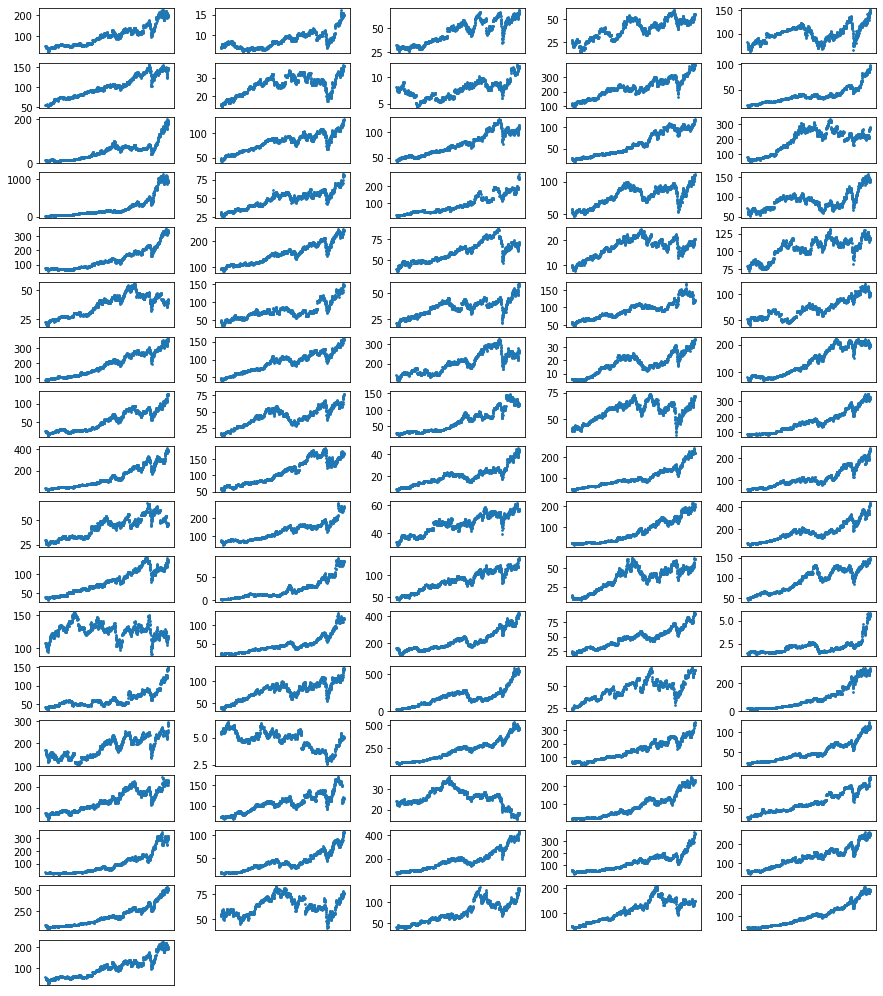

In [154]:
from pyspark.sql.functions import lit
xs, ys = [], []
for s in symbols:
  company_data = spark.read.csv(tech_companies + '/' + s + '.csv', inferSchema=True, header=True)
  company_data = company_data.filter(company_data['Date'] >= (lit(date_after)))
  if company_data.count() >= data_presence_threshold:
    # Date as x
    x = [r['Date'] for r in company_data.select('Date').collect()]
    xs.append(x)

    # Adj close as y
    y = [r['Adj Close'] for r in company_data.select('Adj Close').collect()]
    ys.append(y)

fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=0.2, wspace=0.3)
for i in range(len(xs)+1):
  ax1 = fig.add_subplot(20, 5, i+1)
  ax1.scatter(xs[i-1], ys[i-1], s=3)
  ax1.get_xaxis().set_visible(False)
# # plt.plot(xs, ys)
# plt.ylabel('Adj. Close Price', fontsize=14)
# plt.xlabel('Year', fontsize=14)
# plt.title('Adj. Close Trend', fontsize=14)
# plt.grid(which="both", color='k', linestyle='-', linewidth=0.5)
plt.show()

## Time Series Clustering of Similar Stocks

In [63]:
ysp = np.array([])
for ls in ys:
  ysp = np.append(ysp, ls)
ysp.flatten()

array([  6.97502518,   6.95784616,   6.90201139, ..., 193.1000061 ,
       199.27999878, 198.94000244])

Text(0.5, 0, 'Price')

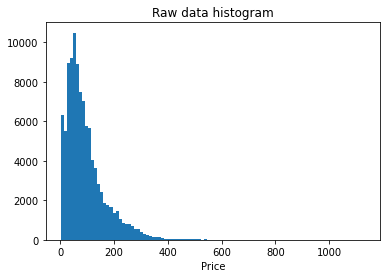

In [98]:
# Is the data Gaussian (i.e. can we standardize it?). No. (but we'll try anyway)
plt.hist(x=ysp, bins=100);
plt.title("Raw data histogram");
plt.xlabel('Price')

In [90]:
# transform
from tslearn.utils import to_time_series_dataset
X = to_time_series_dataset(ys)

# scaled
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
X_scaled_minmax = TimeSeriesScalerMinMax().fit_transform(X)

# lets still try standardizing and see if we get nice clusters
X_scaled_std = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X)

Text(0, 0.5, 'Frequency')

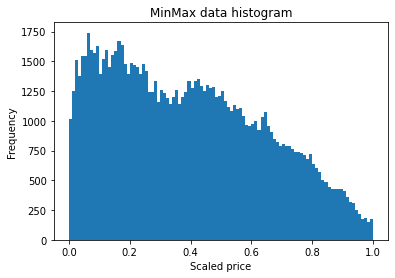

In [101]:
plt.hist(np.array(X_scaled_minmax).flatten(), bins=100);
plt.title("MinMax data histogram");
plt.xlabel('Scaled price')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

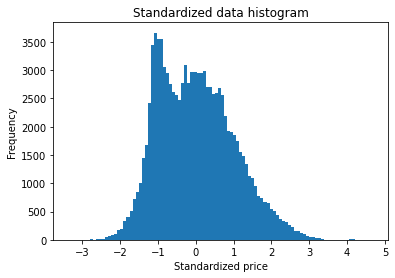

In [102]:
plt.hist(np.array(X_scaled_std).flatten(), bins=100);
plt.title("Standardized data histogram");
plt.xlabel('Standardized price')
plt.ylabel('Frequency')

#### Clusters

In [128]:
from tslearn.clustering import TimeSeriesKMeans
n_clusters = 3

def make_model(X_scaled):
  model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=30)
  return model.fit(X_scaled)

model_minmax = make_model(X_scaled_minmax)
model_std = make_model(X_scaled_std)

In [140]:
def plot_cluster_counts(labels, title):
  sns.countplot(labels)
  plt.title(title)
  plt.ylabel('Number of stocks in cluster')
  plt.xlabel('Cluster')

**Note**: the below cluster labels don't correspond to the same groupings between the two plots.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


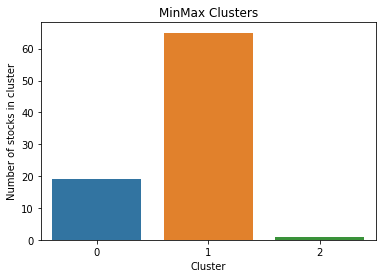

In [141]:
plot_cluster_counts(model_minmax.labels_, title="MinMax Clusters")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


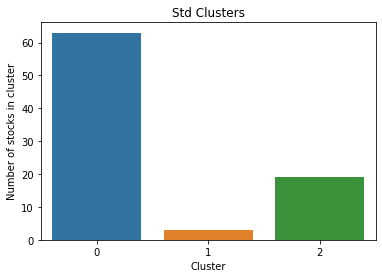

In [142]:
plot_cluster_counts(model_std.labels_, title="Std Clusters")

In [143]:
from collections import defaultdict
def associate(model):
  cluster_to_prices = defaultdict(list)
  cluster_to_dates = defaultdict(list)
  cluster_belonging = defaultdict(list)
  for i, label in enumerate(model.labels_):
    dates, stock_time_series = xs[i], ys[i]
    cluster_to_prices[label].append(stock_time_series)
    cluster_to_dates[label].append(dates)
    cluster_belonging[label].append(symbols[i])

  return cluster_to_prices, cluster_to_dates, cluster_belonging

minmax_cluster_prices, minmax_cluster_dates, minmax_cluster_belonging = associate(model_minmax)
std_cluster_prices, std_cluster_dates, std_cluster_belonging = associate(model_std)

#### Plot each cluster

In [144]:
rgb_values = sns.color_palette("Set2", n_clusters)
color_map = dict(zip(range(n_clusters), rgb_values))

In [145]:
def plot_all(cluster_to_prices, cluster_to_dates, title):
  for label in range(n_clusters):
    c = color_map[label]
    for s in range(len(cluster_to_prices[label])): # for each stock ticker plot it
      cluster_xs = cluster_to_dates[label][s]
      clutser_ys = cluster_to_prices[label][s]
      plt.scatter(cluster_xs, clutser_ys, color=c, s=1, alpha=0.25)
      plt.title(title)
  plt.show()

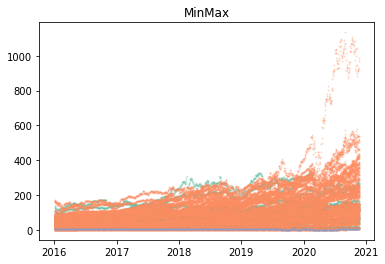

In [146]:
plot_all(minmax_cluster_prices, minmax_cluster_dates, 'MinMax')

In [147]:
def plot_clusters(cluster_to_dates, cluster_to_prices, title):
  fig2 = plt.figure(figsize=(12, 6))
#  fig2.subplots_adjust(hspace=0.2, wspace=0.3)

  for label in range(n_clusters):
    ax2 = fig2.add_subplot(1, 3, label+1)
    c = color_map[label]

    for s in range(len(cluster_to_prices[label])): # for each stock ticker plot it
      cluster_xs = cluster_to_dates[label][s]
      cluster_ys = cluster_to_prices[label][s]
      ax2.title.set_text(f'Cluster {label}')
      ax2.scatter(cluster_xs, cluster_ys, color=c, s=1)
  plt.show()

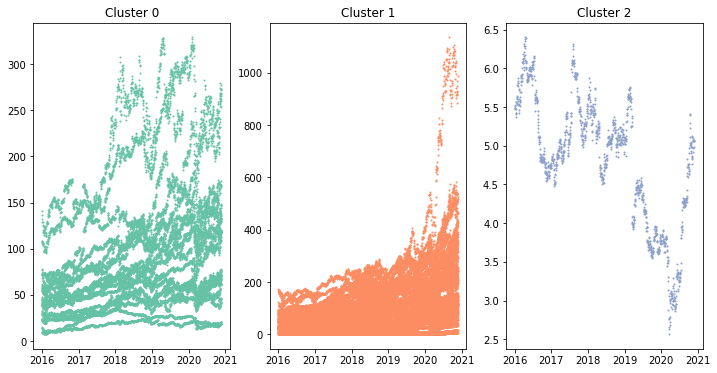

In [148]:
plot_clusters(minmax_cluster_dates, minmax_cluster_prices, 'MinMax')

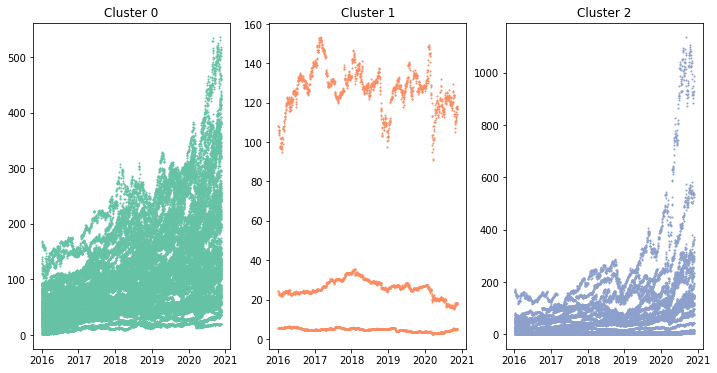

In [149]:
plot_clusters(std_cluster_dates, std_cluster_prices, 'Std')

In [150]:
## Conclusions. Pick top performing cluster and list the stocks in it.